In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import random
import csv
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime

In [3]:
#Get list of s&p 500 companies 
file = open("s&p500-list.csv")
reader = csv.DictReader(file)
symbols = [row['Symbol'] for row in reader]
file.close()
print(symbols[:16])

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN']


In [10]:
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day) #5 years back

#Pick any companies from the list (showing a subset to speed up processing time)
stocks_list = ['ADI', 'AMD', 'NVDA', 'IBM', 'ON']

"""Note: can also take a random sample of n companies by running:
stocks_list = random.sample(symbols, n) 
"""
df = yf.download(stocks_list, start, end)

df.info()

[*********************100%%**********************]  5 of 5 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-01-14 to 2024-01-12
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, ADI)   1259 non-null   float64
 1   (Adj Close, AMD)   1259 non-null   float64
 2   (Adj Close, IBM)   1259 non-null   float64
 3   (Adj Close, NVDA)  1259 non-null   float64
 4   (Adj Close, ON)    1259 non-null   float64
 5   (Close, ADI)       1259 non-null   float64
 6   (Close, AMD)       1259 non-null   float64
 7   (Close, IBM)       1259 non-null   float64
 8   (Close, NVDA)      1259 non-null   float64
 9   (Close, ON)        1259 non-null   float64
 10  (High, ADI)        1259 non-null   float64
 11  (High, AMD)        1259 non-null   float64
 12  (High, IBM)        1259 non-null   float64
 13  (High, NVDA)       1259 non-null   float64
 14  (High, ON)         1259 non-null   float64
 15  (Low, ADI)         1259 non-null   float64
 16  (Low, 

In [5]:
df.describe() 

Adj Close                                                      \
               ADI          AMD          IBM         NVDA           ON   
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    140.912977    78.901104   116.508342   180.547807    46.642780   
std      31.874635    33.070867    15.797241   127.350539    25.351164   
min      76.735916    19.250000    75.172760    32.644440     8.450000   
25%     108.031307    52.299999   104.372662    71.413792    21.700000   
50%     148.039230    82.330002   115.670952   148.084930    41.869999   
75%     165.808334   102.790001   125.149021   233.936852    66.539997   
max     200.880005   161.910004   165.800003   548.219971   108.089996   

             Close                                                      ...  \
               ADI          AMD          IBM         NVDA           ON  ...   
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000  ...   
mean    146.838181    78.901104   130.626542   180.770590    46.642780  ...   
std      29.947253    33.070867    11.120222   127.300574    25.351164  ...   
min      82.230003    19.250000    90.602295    32.900002     8.450000  ...   
25%     115.995003    52.299999   123.231361    71.649998    21.700000  ...   
50%     154.289993    82.330002   130.820007   148.367493    41.869999  ...   
75%     170.800003   102.790001   137.117065   234.129997    66.539997  ...   
max     200.880005   161.910004   165.800003   548.219971   108.089996  ...   

              Open                                                      \
               ADI          AMD          IBM         NVDA           ON   
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    146.785369    78.883209   130.579181   180.629893    46.607220   
std      29.907537    33.090706    11.070301   127.296584    25.312694   
min      82.440002    19.490000    90.439774    33.667500     8.360000   
25%     115.994999    52.264999   123.040001    70.993752    21.750000   
50%     154.589996    82.550003   130.745697   148.009995    42.000000   
75%     170.279999   102.290001   137.047943   234.915001    66.685001   
max     201.940002   163.279999   164.369995   549.989990   109.739998   

             Volume                                                          
                ADI           AMD           IBM          NVDA            ON  
count  1.259000e+03  1.259000e+03  1.259000e+03  1.259000e+03  1.259000e+03  
mean   3.179420e+06  6.608352e+07  4.949431e+06  4.614965e+07  6.904100e+06  
std    1.465639e+06  2.938865e+07  3.032407e+06  1.993614e+07  4.132373e+06  
min    4.664000e+05  1.670590e+07  1.257397e+06  9.788400e+06  1.224100e+06  
25%    2.280100e+06  4.537630e+07  3.321850e+06  3.240120e+07  4.683850e+06  
50%    2.941300e+06  5.823480e+07  4.204100e+06  4.285080e+07  6.097500e+06  
75%    3.735100e+06  7.996270e+07  5.540296e+06  5.602200e+07  8.136200e+06  
max    1.915640e+07  2.253941e+08  3.981442e+07  2.511528e+08  9.318090e+07  

[8 rows x 30 columns]

## Data preprocessing 
Fill spaces in null columns with the means of the ~10 entries (less if closer to top or bottom) above and below them.

In [6]:
def avg(series):
    for i in range(len(series)):
        if pd.isnull(series[i]):
            start = max(0, i - 10)
            end = min(len(series), i + 11)
            avg = series[start:end].mean()
            series[i] = avg
    return series

df = df.apply(avg, axis=0)
df.head()


/tmp/ipykernel_1810/1453454734.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isnull(series[i]):


Adj Close                                                  Close  \
                  ADI        AMD        IBM       NVDA         ON        ADI   
Date                                                                           
2019-01-14  79.575150  20.230000  90.182587  37.317860  17.709999  87.500000   
2019-01-15  79.675194  20.379999  91.186356  37.176468  17.840000  87.610001   
2019-01-16  79.120422  19.730000  91.103966  36.920971  17.629999  87.000000   
2019-01-17  80.766518  20.250000  91.530922  37.635368  17.820000  88.809998   
2019-01-18  83.085564  20.770000  92.751953  38.927765  18.410000  91.360001   

                                                         ...       Open  \
                  AMD         IBM       NVDA         ON  ...        ADI   
Date                                                     ...              
2019-01-14  20.230000  115.095604  37.610001  17.709999  ...  88.680000   
2019-01-15  20.379999  116.376671  37.467499  17.840000  ...  87.660004   
2019-01-16  19.730000  116.271507  37.209999  17.629999  ...  87.599998   
2019-01-17  20.250000  116.816444  37.930000  17.820000  ...  86.510002   
2019-01-18  20.770000  118.374763  39.232498  18.410000  ...  89.610001   

                                                          Volume            \
                  AMD         IBM       NVDA         ON      ADI       AMD   
Date                                                                         
2019-01-14  19.959999  115.210327  36.680000  18.110001  2239300  71350200   
2019-01-15  20.440001  115.640533  37.939999  17.820000  1960500  62785800   
2019-01-16  20.400000  116.233269  37.742500  17.900000  1667100  70849300   
2019-01-17  19.490000  115.258125  36.877499  17.440001  2563000  85018400   
2019-01-18  20.370001  117.848946  38.432499  17.900000  3471600  88131000   

                                        
                IBM      NVDA       ON  
Date                                    
2019-01-14  5469220  73016800  6465300  
2019-01-15  3668845  61701200  4061200  
2019-01-16  4017791  47010400  3422800  
2019-01-17  5261275  49343600  6039700  
2019-01-18  6284891  65133600  5807700  

[5 rows x 30 columns]

## Data visualization
Use matplotlib to plot a variety of features, including adjusted close price (close price after adjustments are made for dividend payouts and stock splits as outlined in CRSP standards), daily return percentage and 10-day exponential moving average.

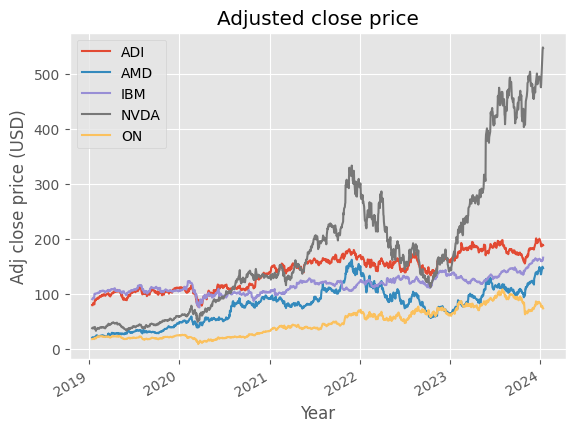

In [7]:
df['Adj Close'].plot(legend=True, title='Adjusted close price',xlabel='Year', ylabel='Adj close price (USD)')
plt.show()

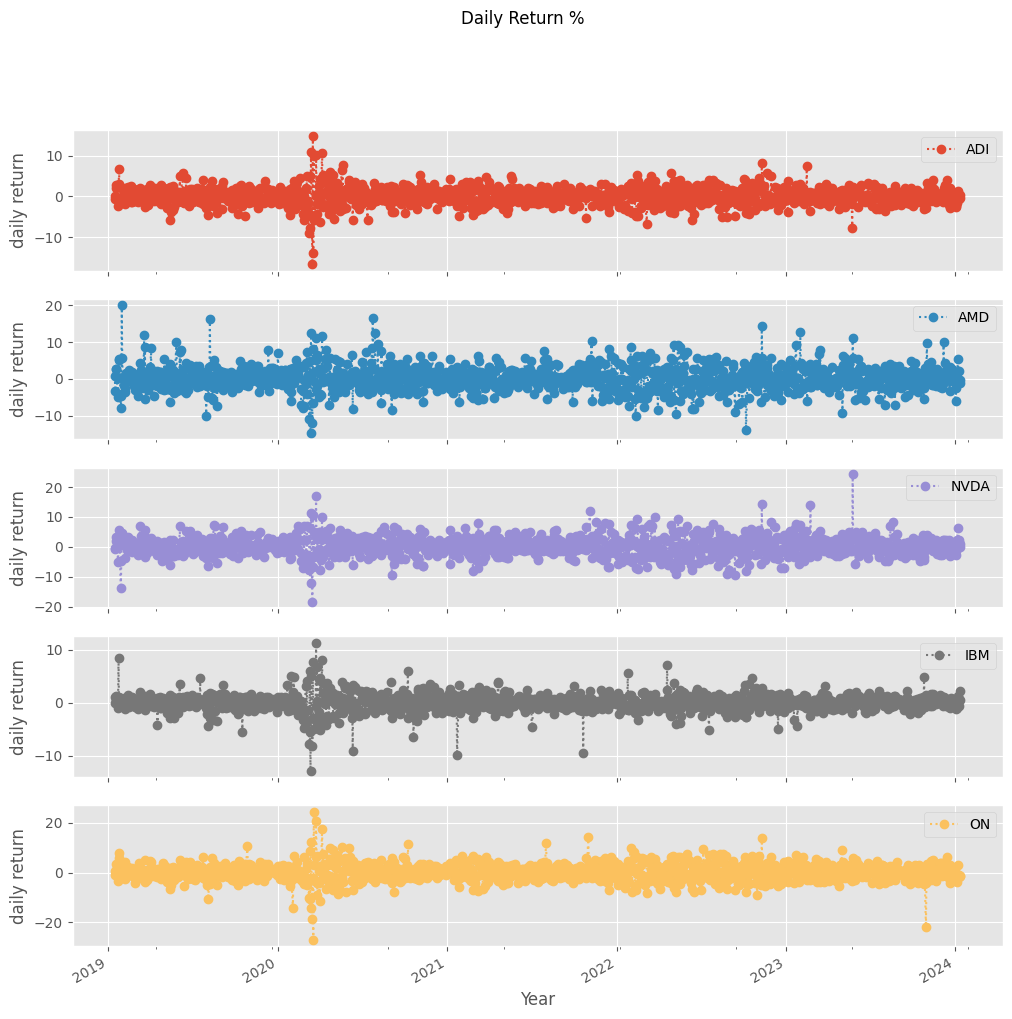

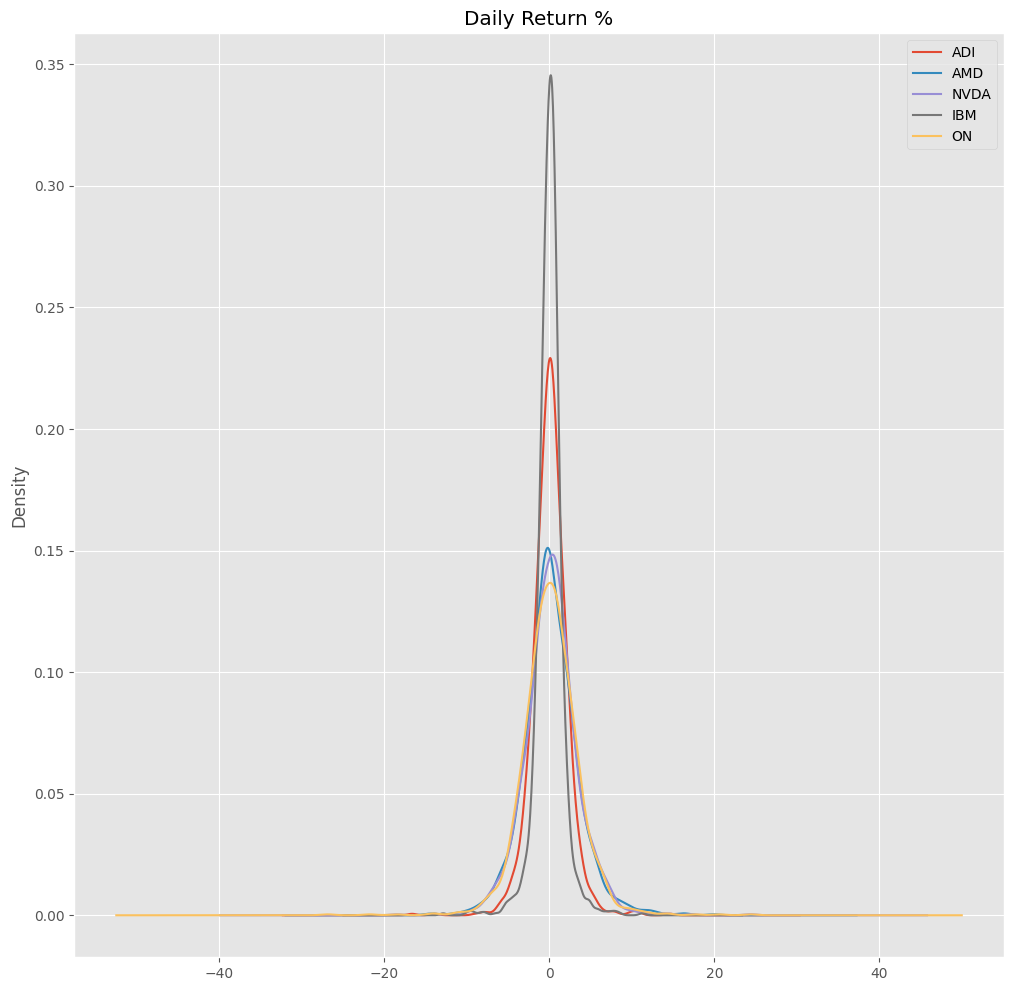

In [81]:
for stock in stocks_list:
    df['Daily Return', stock] = df['Adj Close', stock].pct_change()*100
df['Daily Return'].plot(title='Daily Return %', xlabel='Year', ylabel='daily return',figsize=(12,12),legend=True,subplots=True,linestyle=':',marker='o')
plt.show()
df['Daily Return'].plot.kde(title='Daily Return %', xlabel='Year', ylabel='daily return',figsize=(12,12),legend=True)
plt.show()

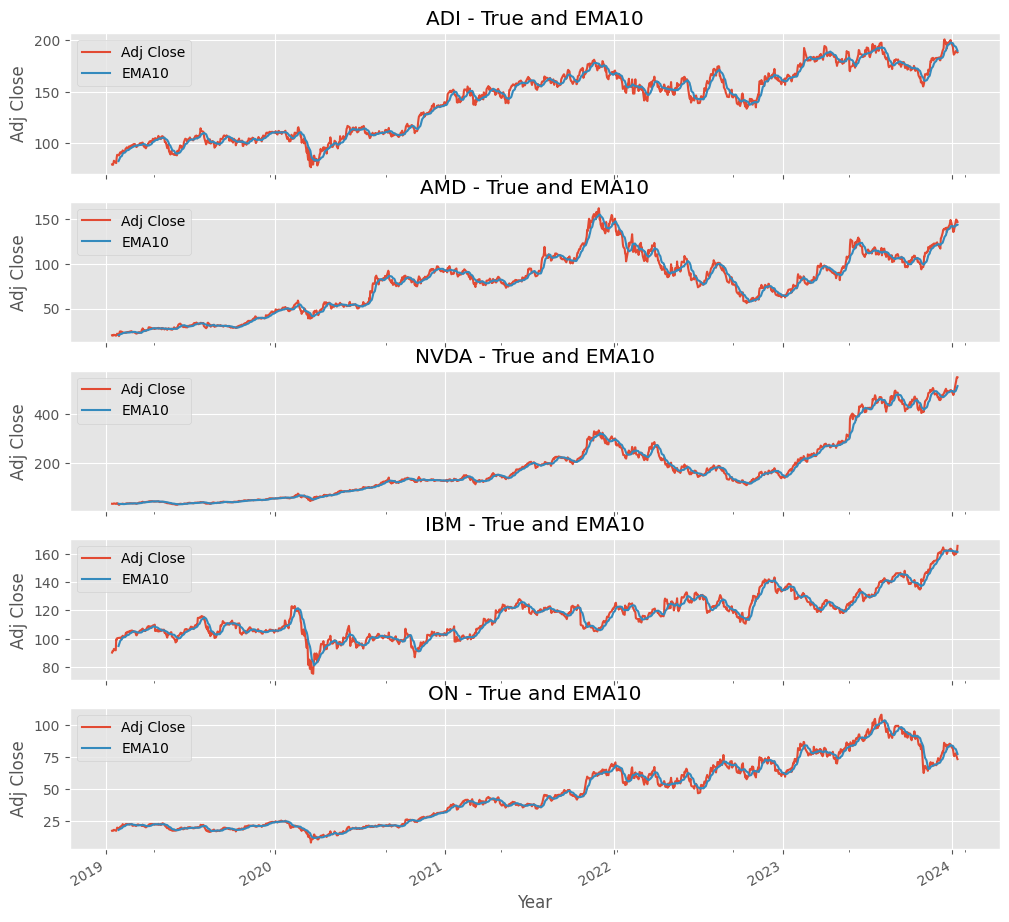

In [8]:
fig, axes = plt.subplots(nrows=len(stocks_list), ncols=1, figsize=(12, 5 * len(stocks_list)), sharex=True)

for i, stock in enumerate(stocks_list):
    df['EMA10', stock] = df['Adj Close', stock].rolling(10).mean()
    # Plot 'Adj Close' and EMA10 for each stock in separate subplots
    df_plot = df[[('Adj Close', stock), ('EMA10', stock)]]
    ax = df_plot.plot(ax=axes[i], ylabel='Adj Close', xlabel='Year', legend=False,title=f'{stock} - True and EMA10', figsize=(12, 12))

    lines, labels = ax.get_legend_handles_labels()
    labels = ['Adj Close', 'EMA10']
    ax.legend(lines, labels)


## Training
We will begin by splitting the dataset into training/validation and testing data. Then we can begin training the model using a CNN, and pass the results to LSTM layers. 

In [68]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size - 1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2

model = tf.keras.Sequential()

# CNN 
model.add(TimeDistributed(Conv1D(64, kernel_size=5, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=5, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=5, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

# LSTM 
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=24, batch_size=60)

Epoch 1/24
16/16 [==============================] - 7s 99ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/24
16/16 [==============================] - 0s 30ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/24
16/16 [==============================] - 0s 28ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/24
16/16 [==============================] - 0s 29ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 5/24
16/16 [==============================] - 0s 31ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 6/24
16/16 [==============================] - 0s 31ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 7/24
16/16 [==============================] - 1s 35ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 8.2182e-04 - val_mse: 8.2182e-04
Epoch 8/24
16/16 [==============================] - 0s 29ms/step - loss: 0.

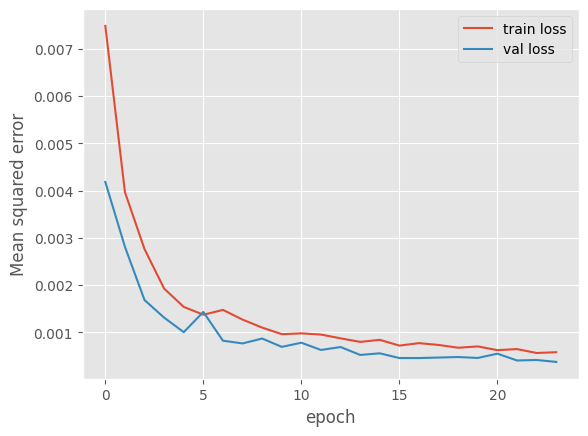

In [78]:
plt.plot(history.history['mse'], label='train loss')
plt.plot(history.history['val_mse'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Mean squared error") #MSE chosen over MAE since few outliers in dataset
plt.legend()

In [81]:
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

r2 = r2_score(test_Y.reshape(-1,1), (model.predict(test_X, verbose=0))[:, 0])
print('R2 Score: %f' % r2)

err = max_error(test_Y.reshape(-1,1), (model.predict(test_X, verbose=0))[:, 0])
print('Max Error: %f' % err)

R2 Score: 0.963843
Max Error: 0.085121


8/8 [==============================] - 0s 5ms/step


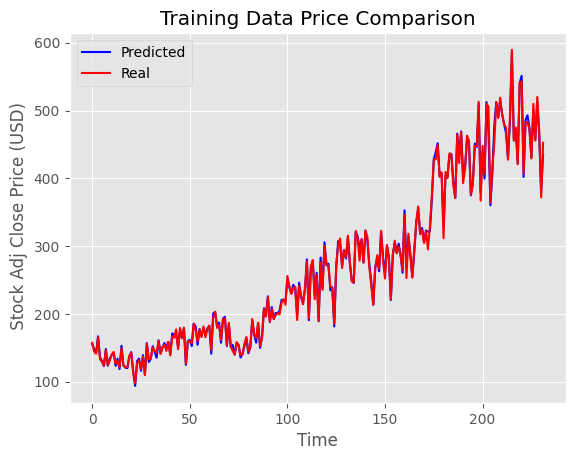

In [82]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = df.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
    
plt.plot(predicted, color = 'blue', label = 'Predicted')
plt.plot(test_label, color = 'red', label = 'Real')
plt.title('Training Data Price Comparison')
plt.xlabel('Time')
plt.ylabel(' Stock Adj Close Price (USD)')
plt.legend()
plt.show()

## Testing
We can now use the testing (never before seen) data to evaluate the model.

8/8 [==============================] - 0s 5ms/step


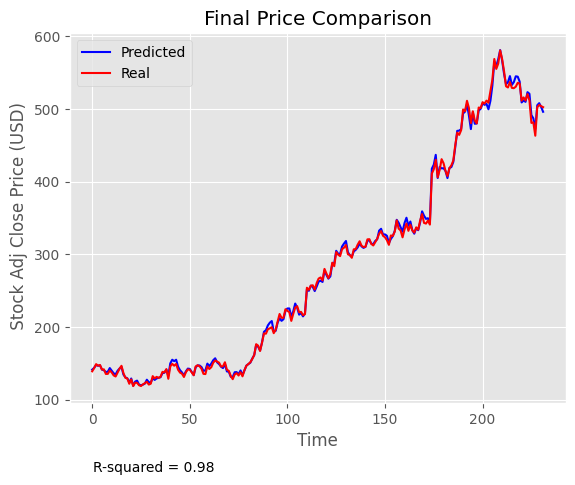

In [90]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)


model.evaluate(test_X, test_Y)
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)


# Calculate R-squared
r2 = r2_score(test_label, predicted)

predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = df.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp

plt.plot(predicted, color = 'blue', label = 'Predicted')
plt.plot(test_label, color = 'red', label = 'Real')
plt.title('Final Price Comparison')
plt.xlabel('Time')
plt.text(0.6, 0.5, 'R-squared = %0.2f' % r2)
plt.ylabel(' Stock Adj Close Price (USD)')
plt.legend()
plt.show()